<a href="https://colab.research.google.com/github/poojagupta14/PowerGrid_Cyber-Attack/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ipaddress
from scipy import stats
from scipy.stats import chi2_contingency  #hypothesis testing
from datetime import datetime, timedelta
import math
import missingno as msno  #to get a missing value graph
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore') 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = 'drive/MyDrive/BTP/Cybersecurity_attacks.csv'
df = pd.read_csv(path)

In [5]:
df.shape

(178031, 11)

In [6]:
df.columns

Index(['Attack category', 'Attack subcategory', 'Protocol', 'Source IP',
       'Source Port', 'Destination IP', 'Destination Port', 'Attack Name',
       'Attack Reference', '.', 'Time'],
      dtype='object')

In [7]:
df.head()

,Attack category,Attack subcategory,Protocol,Source IP,Source Port,Destination IP,Destination Port,Attack Name,Attack Reference,.,Time
0,Reconnaissance,HTTP,tcp,175.45.176.0,13284,149.171.126.16,80,Domino Web Server Database Access: /doladmin.n...,-,.,1421927414-1421927416
1,Exploits,Unix 'r' Service,udp,175.45.176.3,21223,149.171.126.18,32780,Solaris rwalld Format String Vulnerability (ht...,CVE 2002-0573 (http://cve.mitre.org/cgi-bin/cv...,.,1421927415-1421927415
2,Exploits,Browser,tcp,175.45.176.2,23357,149.171.126.16,80,Windows Metafile (WMF) SetAbortProc() Code Exe...,CVE 2005-4560 (http://cve.mitre.org/cgi-bin/cv...,.,1421927416-1421927416
3,Exploits,Miscellaneous Batch,tcp,175.45.176.2,13792,149.171.126.16,5555,HP Data Protector Backup (https://strikecenter...,CVE 2011-1729 (http://cve.mitre.org/cgi-bin/cv...,.,1421927417-1421927417
4,Exploits,Cisco IOS,tcp,175.45.176.2,26939,149.171.126.10,80,Cisco IOS HTTP Authentication Bypass Level 64 ...,CVE 2001-0537 (http://cve.mitre.org/cgi-bin/cv...,.,1421927418-1421927418


In [8]:
df[['Start time','Last time']] = df['Time'].str.split('-',expand=True)
df = df.drop(['.', 'Time'],axis=1)  #drop the columns not required
df.head()

,Attack category,Attack subcategory,Protocol,Source IP,Source Port,Destination IP,Destination Port,Attack Name,Attack Reference,Start time,Last time
0,Reconnaissance,HTTP,tcp,175.45.176.0,13284,149.171.126.16,80,Domino Web Server Database Access: /doladmin.n...,-,1421927414,1421927416
1,Exploits,Unix 'r' Service,udp,175.45.176.3,21223,149.171.126.18,32780,Solaris rwalld Format String Vulnerability (ht...,CVE 2002-0573 (http://cve.mitre.org/cgi-bin/cv...,1421927415,1421927415
2,Exploits,Browser,tcp,175.45.176.2,23357,149.171.126.16,80,Windows Metafile (WMF) SetAbortProc() Code Exe...,CVE 2005-4560 (http://cve.mitre.org/cgi-bin/cv...,1421927416,1421927416
3,Exploits,Miscellaneous Batch,tcp,175.45.176.2,13792,149.171.126.16,5555,HP Data Protector Backup (https://strikecenter...,CVE 2011-1729 (http://cve.mitre.org/cgi-bin/cv...,1421927417,1421927417
4,Exploits,Cisco IOS,tcp,175.45.176.2,26939,149.171.126.10,80,Cisco IOS HTTP Authentication Bypass Level 64 ...,CVE 2001-0537 (http://cve.mitre.org/cgi-bin/cv...,1421927418,1421927418


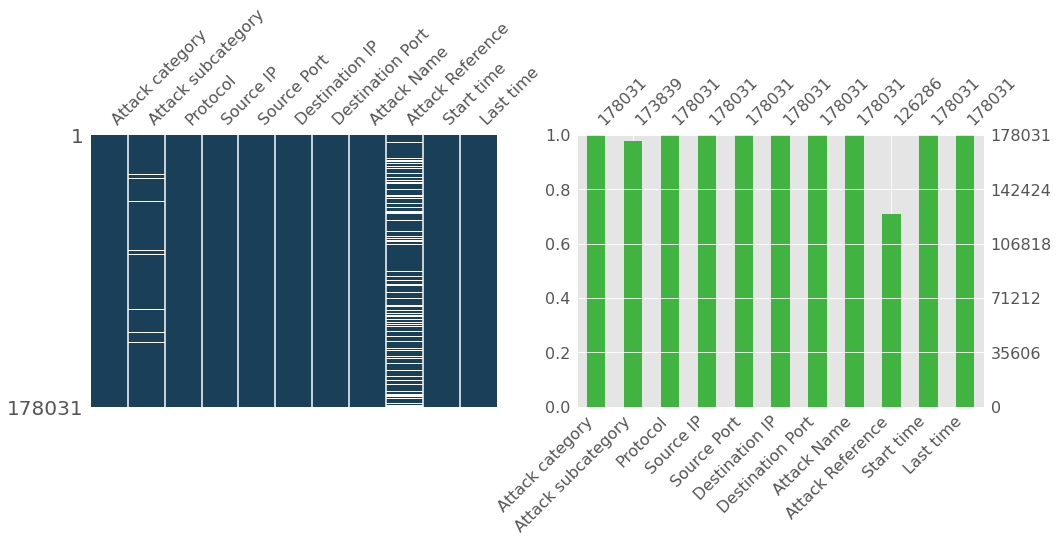

In [9]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
msno.matrix(df, ax=ax1, sparkline=False, color=(0.1, 0.25, 0.35))  #to check missing values
msno.bar(df, ax=ax2, color=(0.25, 0.7, 0.25))
plt.show()

In [10]:
df.isnull().sum()

Attack category           0
Attack subcategory     4192
Protocol                  0
Source IP                 0
Source Port               0
Destination IP            0
Destination Port          0
Attack Name               0
Attack Reference      51745
Start time                0
Last time                 0
dtype: int64

In [11]:
df['Attack subcategory'] = df['Attack subcategory'].fillna("Not Registered") #whatever value is missing in the 'Attack subcategory', will convert in Not registerd
df.isnull().sum()

Attack category           0
Attack subcategory        0
Protocol                  0
Source IP                 0
Source Port               0
Destination IP            0
Destination Port          0
Attack Name               0
Attack Reference      51745
Start time                0
Last time                 0
dtype: int64

In [12]:
df[pd.isnull(df).any(axis=1)].shape

(51745, 11)

In [13]:
df[df.duplicated()].shape  #to get the no. of rows which are duplicate

(6, 11)

In [14]:
print('dimensions before dropping duplicated rows: ' + str(df.shape))
df = df.drop(df[df.duplicated()].index)  #to drop the duplicate rows
print('dimensions after dropping duplicated rows: ' + str(df.shape))

dimensions before dropping duplicated rows: (178031, 11)
dimensions after dropping duplicated rows: (178025, 11)


In [15]:
df[df.duplicated()]

,Attack category,Attack subcategory,Protocol,Source IP,Source Port,Destination IP,Destination Port,Attack Name,Attack Reference,Start time,Last time


In [16]:
# port range can be from 0 to 65535 so we need to remove invalid source and destination ports
invalid_SP = (df['Source Port'] < 0) | (df['Source Port'] > 65535)
invalid_DP = (df['Destination Port'] < 0) | (df['Destination Port'] > 65535)
df[invalid_SP | invalid_DP]  #to get the dataframe of invalid ports

,Attack category,Attack subcategory,Protocol,Source IP,Source Port,Destination IP,Destination Port,Attack Name,Attack Reference,Start time,Last time
174347,Generic,IXIA,udp,175.45.176.1,67520,149.171.126.18,53,Microsoft_DNS_Server_ANY_Query_Cache_Weakness_...,CVE 2005-4092 (http://cve.mitre.org/cgi-bin/cv...,1421933561,1421933561
174348,Exploits,Browser,tcp,175.45.176.3,78573,149.171.126.18,110,Microsoft Internet Explorer 6.0 Png pngfilt.dl...,BPS 2010-0002 (https://strikecenter.bpointsys....,1421932490,1421932491
174349,Reconnaissance,HTTP,tcp,175.45.176.1,71804,149.171.126.10,80,Domino Web Server Database Access: /internet.n...,NaN,1424236143,1424236143
174350,DoS,Ethernet,pnni,175.45.176.3,0,149.171.126.19,-753,Cisco IPS Jumbo Frame System Crash (https://st...,CVE 2008-2060 (http://cve.mitre.org/cgi-bin/cv...,1424230284,1424230284
174351,Fuzzers,OSPF,trunk-1,175.45.176.0,73338,149.171.126.13,0,Fuzzer: OSPF Hello Packet: Long Neighbor Lists...,NaN,1424223172,1424223172
...,...,...,...,...,...,...,...,...,...,...,...
178026,Generic,IXIA,udp,175.45.176.0,72349,149.171.126.12,53,Microsoft_DNS_Server_ANY_Query_Cache_Weakness_...,CVE 2009-0234 (http://cve.mitre.org/cgi-bin/cv...,1424224338,1424224338
178027,Exploits,Browser,sep,175.45.176.3,67647,149.171.126.18,0,Persits XUpload ActiveX Method MakeHttpRequest...,CVE 2009-3693 (http://cve.mitre.org/cgi-bin/cv...,1424249567,1424249567
178028,Exploits,Office Document,tcp,175.45.176.0,78359,149.171.126.13,110,Microsoft Excel SxView Memory Corruption (POP3...,CVE 2009-3128 (http://cve.mitre.org/cgi-bin/cv...,1424219921,1424219923
178029,Exploits,Browser,tcp,175.45.176.2,68488,149.171.126.19,80,Internet Explorer createTextRange() Code Execu...,CVE 2006-1359 (http://cve.mitre.org/cgi-bin/cv...,1424247789,1424247789


In [17]:
df = df[~(invalid_SP | invalid_DP)].reset_index(drop=True) #drop the invalid ports from our dataframe

In [18]:
print('total no. of different protocols:', len(df['Protocol'].unique()))
print('total no. of different Attack categories:', len(df['Attack category'].unique()))
df['Protocol'].unique()[:15]

total no. of different protocols: 131
total no. of different Attack categories: 14


array(['tcp', 'udp', 'Tcp', 'UDP', 'ospf', 'sctp', 'sep', 'mobile',
       'sun-nd', 'swipe', 'pim', 'ggp', 'ip', 'ipnip', 'st2'],
      dtype=object)

In [19]:
df['Attack category'].unique()

array(['Reconnaissance', 'Exploits', 'DoS', 'Generic', 'Shellcode',
       ' Fuzzers', 'Worms', 'Backdoors', 'Analysis', ' Fuzzers ',
       ' Reconnaissance ', 'Backdoor', ' Shellcode ', 'Reconnaissance '],
      dtype=object)

In [20]:
df['Protocol'] = df['Protocol'].str.upper().str.strip() 
df['Attack category'] = df['Attack category'].str.upper().str.strip()
df['Attack category'] = df['Attack category'].str.strip().replace('BACKDOORS','BACKDOOR')
df

,Attack category,Attack subcategory,Protocol,Source IP,Source Port,Destination IP,Destination Port,Attack Name,Attack Reference,Start time,Last time
0,RECONNAISSANCE,HTTP,TCP,175.45.176.0,13284,149.171.126.16,80,Domino Web Server Database Access: /doladmin.n...,-,1421927414,1421927416
1,EXPLOITS,Unix 'r' Service,UDP,175.45.176.3,21223,149.171.126.18,32780,Solaris rwalld Format String Vulnerability (ht...,CVE 2002-0573 (http://cve.mitre.org/cgi-bin/cv...,1421927415,1421927415
2,EXPLOITS,Browser,TCP,175.45.176.2,23357,149.171.126.16,80,Windows Metafile (WMF) SetAbortProc() Code Exe...,CVE 2005-4560 (http://cve.mitre.org/cgi-bin/cv...,1421927416,1421927416
3,EXPLOITS,Miscellaneous Batch,TCP,175.45.176.2,13792,149.171.126.16,5555,HP Data Protector Backup (https://strikecenter...,CVE 2011-1729 (http://cve.mitre.org/cgi-bin/cv...,1421927417,1421927417
4,EXPLOITS,Cisco IOS,TCP,175.45.176.2,26939,149.171.126.10,80,Cisco IOS HTTP Authentication Bypass Level 64 ...,CVE 2001-0537 (http://cve.mitre.org/cgi-bin/cv...,1421927418,1421927418
...,...,...,...,...,...,...,...,...,...,...,...
174336,DOS,IGMP,TCP,175.45.176.0,33654,149.171.126.12,80,Microsoft IIS Repeated Parameter Request Denia...,CVE 2010-1899 (http://cve.mitre.org/cgi-bin/cv...,1424262066,1424262069
174337,FUZZERS,SMB,TCP,175.45.176.3,36468,149.171.126.15,445,Fuzzer: SMB Session Setup Invalid Username (NT...,NaN,1424262067,1424262068
174338,RECONNAISSANCE,SunRPC Portmapper (TCP) UDP Service,TCP,175.45.176.2,64395,149.171.126.18,111,SunRPC TCP Portmapper GETPORT Request (ippathv...,NaN,1424262067,1424262068
174339,GENERIC,IXIA,UDP,175.45.176.0,47439,149.171.126.10,53,Microsoft_DNS_Server_ANY_Query_Cache_Weakness_...,CVE 2009-0234 (http://cve.mitre.org/cgi-bin/cv...,1424262068,1424262068


In [21]:
print('total no. of different protocols:', len(df['Protocol'].unique()))
print('total no. of different Attack categories:', len(df['Attack category'].unique()))

total no. of different protocols: 129
total no. of different Attack categories: 9


In [22]:
print(df[pd.isnull(df['Attack Reference'])]['Attack category'].value_counts())  #to know how many Attack Reference are missing from each Attack category

FUZZERS           29649
RECONNAISSANCE    18149
ANALYSIS           1617
SHELLCODE           747
GENERIC             341
BACKDOOR             66
DOS                  53
WORMS                11
EXPLOITS              5
Name: Attack category, dtype: int64


In [23]:
print(df['Attack category'].value_counts()) 

EXPLOITS          68211
FUZZERS           33638
DOS               24582
RECONNAISSANCE    20136
GENERIC           19860
BACKDOOR           4353
ANALYSIS           1881
SHELLCODE          1511
WORMS               169
Name: Attack category, dtype: int64


In [24]:
# % of missing values in 'Attack Reference' per Attack Category
((df[pd.isnull(df['Attack Reference'])]['Attack category'].value_counts()/df['Attack category'].value_counts())*100).dropna().sort_values(ascending=False)

RECONNAISSANCE    90.132102
FUZZERS           88.141388
ANALYSIS          85.964912
SHELLCODE         49.437459
WORMS              6.508876
GENERIC            1.717019
BACKDOOR           1.516196
DOS                0.215605
EXPLOITS           0.007330
Name: Attack category, dtype: float64

In [25]:
path2 = 'drive/MyDrive/BTP/TCP-ports.csv'
tcp_ports = pd.read_csv(path2)
tcp_ports['Service'] = tcp_ports['Service'].str.upper()
tcp_ports.head()

,Port,Service,Description
0,0,NaN,Reserved
1,1,TCPMUX,TCP Port Service Multiplexer
2,2,COMPRESSNET,Management Utility
3,3,COMPRESSNET,Compression Process
4,5,RJE,Remote Job Entry


In [26]:
print('dimensions before merging dataframes: ' ,(df.shape))
newdf = pd.merge(df, tcp_ports[['Port','Service']], left_on='Destination Port', right_on='Port', how='left') #merge both datasets reqd information
newdf = newdf.rename(columns={'Service':'Destination Port Service'})
print('dimensions after merging dataframes: ' + str(newdf.shape))

dimensions before merging dataframes:  (174341, 11)
dimensions after merging dataframes: (174341, 13)


In [27]:
newdf = newdf.drop(columns=['Port'])
newdf.head()

,Attack category,Attack subcategory,Protocol,Source IP,Source Port,Destination IP,Destination Port,Attack Name,Attack Reference,Start time,Last time,Destination Port Service
0,RECONNAISSANCE,HTTP,TCP,175.45.176.0,13284,149.171.126.16,80,Domino Web Server Database Access: /doladmin.n...,-,1421927414,1421927416,HTTP
1,EXPLOITS,Unix 'r' Service,UDP,175.45.176.3,21223,149.171.126.18,32780,Solaris rwalld Format String Vulnerability (ht...,CVE 2002-0573 (http://cve.mitre.org/cgi-bin/cv...,1421927415,1421927415,NaN
2,EXPLOITS,Browser,TCP,175.45.176.2,23357,149.171.126.16,80,Windows Metafile (WMF) SetAbortProc() Code Exe...,CVE 2005-4560 (http://cve.mitre.org/cgi-bin/cv...,1421927416,1421927416,HTTP
3,EXPLOITS,Miscellaneous Batch,TCP,175.45.176.2,13792,149.171.126.16,5555,HP Data Protector Backup (https://strikecenter...,CVE 2011-1729 (http://cve.mitre.org/cgi-bin/cv...,1421927417,1421927417,PERSONAL-AGENT
4,EXPLOITS,Cisco IOS,TCP,175.45.176.2,26939,149.171.126.10,80,Cisco IOS HTTP Authentication Bypass Level 64 ...,CVE 2001-0537 (http://cve.mitre.org/cgi-bin/cv...,1421927418,1421927418,HTTP


In [28]:
# now our data cleaning has been done
newdf['Attack category'].unique()

array(['RECONNAISSANCE', 'EXPLOITS', 'DOS', 'GENERIC', 'SHELLCODE',
       'FUZZERS', 'WORMS', 'BACKDOOR', 'ANALYSIS'], dtype=object)

In [29]:
newdf['Attack category'].value_counts()

EXPLOITS          68211
FUZZERS           33638
DOS               24582
RECONNAISSANCE    20136
GENERIC           19860
BACKDOOR           4353
ANALYSIS           1881
SHELLCODE          1511
WORMS               169
Name: Attack category, dtype: int64

In [30]:
newdf['Attack category'].value_counts()*100/newdf['Attack category'].value_counts().sum()

EXPLOITS          39.125048
FUZZERS           19.294371
DOS               14.099954
RECONNAISSANCE    11.549779
GENERIC           11.391468
BACKDOOR           2.496831
ANALYSIS           1.078920
SHELLCODE          0.866692
WORMS              0.096936
Name: Attack category, dtype: float64

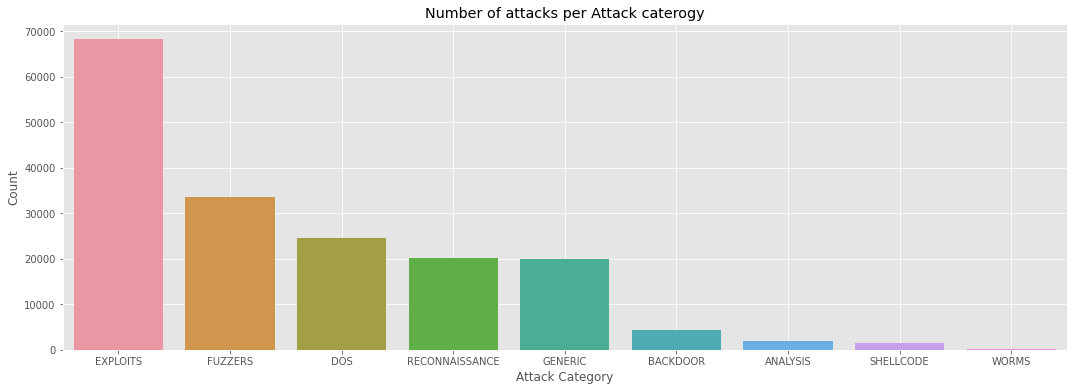

In [31]:
plt.figure(figsize=(18,6))
sns.barplot(x=newdf['Attack category'].value_counts().index,y=newdf['Attack category'].value_counts())
plt.xlabel('Attack Category')
plt.ylabel('Count')
plt.title('Number of attacks per Attack caterogy')
plt.grid(True)

In [32]:
pd.DataFrame(newdf['Attack category'].value_counts())[:]

,Attack category
EXPLOITS,68211
FUZZERS,33638
DOS,24582
RECONNAISSANCE,20136
GENERIC,19860
BACKDOOR,4353
ANALYSIS,1881
SHELLCODE,1511
WORMS,169


In [33]:
a=pd.DataFrame(newdf['Attack category'].value_counts())[:6]

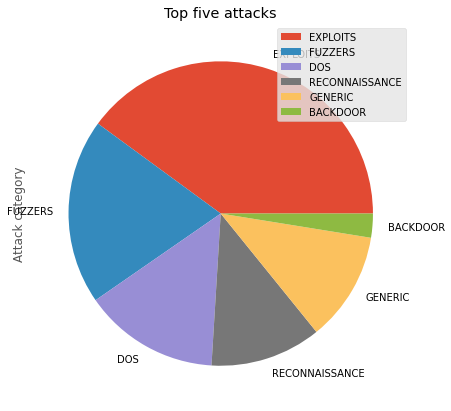

In [34]:
a.plot(kind='pie', subplots=True, figsize=(7, 7))
plt.title('Top five attacks')
plt.legend(loc='left')
plt.show()

In [35]:
# now we need to analyse with Date and Time
newdf['Start time']

0         1421927414
1         1421927415
2         1421927416
3         1421927417
4         1421927418
             ...    
174336    1424262066
174337    1424262067
174338    1424262067
174339    1424262068
174340    1424262068
Name: Start time, Length: 174341, dtype: object

In [36]:
newdf['Start time'] = pd.to_datetime(newdf['Start time'], unit='s')
newdf['Last time'] = pd.to_datetime(newdf['Last time'], unit='s')
newdf['Duration'] = ((newdf['Last time'] - newdf['Start time']).dt.seconds).astype(int)
newdf[:5]

,Attack category,Attack subcategory,Protocol,Source IP,Source Port,Destination IP,Destination Port,Attack Name,Attack Reference,Start time,Last time,Destination Port Service,Duration
0,RECONNAISSANCE,HTTP,TCP,175.45.176.0,13284,149.171.126.16,80,Domino Web Server Database Access: /doladmin.n...,-,2015-01-22 11:50:14,2015-01-22 11:50:16,HTTP,2
1,EXPLOITS,Unix 'r' Service,UDP,175.45.176.3,21223,149.171.126.18,32780,Solaris rwalld Format String Vulnerability (ht...,CVE 2002-0573 (http://cve.mitre.org/cgi-bin/cv...,2015-01-22 11:50:15,2015-01-22 11:50:15,NaN,0
2,EXPLOITS,Browser,TCP,175.45.176.2,23357,149.171.126.16,80,Windows Metafile (WMF) SetAbortProc() Code Exe...,CVE 2005-4560 (http://cve.mitre.org/cgi-bin/cv...,2015-01-22 11:50:16,2015-01-22 11:50:16,HTTP,0
3,EXPLOITS,Miscellaneous Batch,TCP,175.45.176.2,13792,149.171.126.16,5555,HP Data Protector Backup (https://strikecenter...,CVE 2011-1729 (http://cve.mitre.org/cgi-bin/cv...,2015-01-22 11:50:17,2015-01-22 11:50:17,PERSONAL-AGENT,0
4,EXPLOITS,Cisco IOS,TCP,175.45.176.2,26939,149.171.126.10,80,Cisco IOS HTTP Authentication Bypass Level 64 ...,CVE 2001-0537 (http://cve.mitre.org/cgi-bin/cv...,2015-01-22 11:50:18,2015-01-22 11:50:18,HTTP,0


In [37]:
newdf['Start time'].astype(str).str.split(' ').str[0].unique() #to know within which Dates data is available

array(['2015-01-22', '2015-02-18'], dtype=object)

In [38]:
newdf.describe()

,Source Port,Destination Port,Duration
count,174341.000000,174341.000000,174341.000000
mean,15391.130382,1304.599423,2.341572
std,21707.824000,7466.035607,9.309381
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,31862.000000,80.000000,1.000000
max,65535.000000,65535.000000,60.000000


In [39]:
# Mean and 75% is very different for Source and Destination port, however minimum and maximum is same. Thus, here comes the Hypothesis testing.
# We can obtain one of two results (i.e. H0:μ1=μ2   Ha:μ1≠μ2) from the test.
# If the  p -value is less than our significance level ( p<α ) we reject the null hypothesis  H0  and affirm that the observed difference is statistically significant.
# If the  p -value is greater than our significance level ( p>α ) we will have to retain  H0  and conclude that the observed difference is not statistically significant.
# The hypothesis test is conducted using a statistical  T−test  which specifies the two Series df_interest['Source Port'] and df_interest['Destination Port']. 
# By specifying these two Series, we are automatically referring to a comparative test of the means of both Series.
statistic, pvalue = stats.ttest_ind( newdf['Source Port'], newdf['Destination Port'], equal_var=False)
print('p-value in T-test: ' + str(pvalue))

p-value in T-test: 0.0


In [ ]:
# As the  p-value is very close to zero, python approximates this measurement to 0.0, with this in mind, we can reject the null hypothesis  H0  regarding the equality of the means of the source and destination ports.
# This means that the source port of the attacks is very different from the destination port.
# In this way, most attacks are directed at specific logical ports, which does not leave a random spot
# Now we will be using two methods for correlation calculation: 
# Pearson's correlation: evaluates the linear relationships between two variables. If the value is close to 0, there is a weak or nonexistent linear relationship between the variables.
#Spearman's correlation: evaluates the monotonic relationships between two variables. If the value is close to 0, there is a weak or nonexistent monotonic relationship between the variables.

In [40]:
newdf.corr(method='pearson')

,Source Port,Destination Port,Duration
Source Port,1.000000,0.137155,-0.078024
Destination Port,0.137155,1.000000,-0.026770
Duration,-0.078024,-0.026770,1.000000


In [41]:
newdf.corr(method='spearman')

,Source Port,Destination Port,Duration
Source Port,1.000000,0.885328,0.361013
Destination Port,0.885328,1.000000,0.346909
Duration,0.361013,0.346909,1.000000


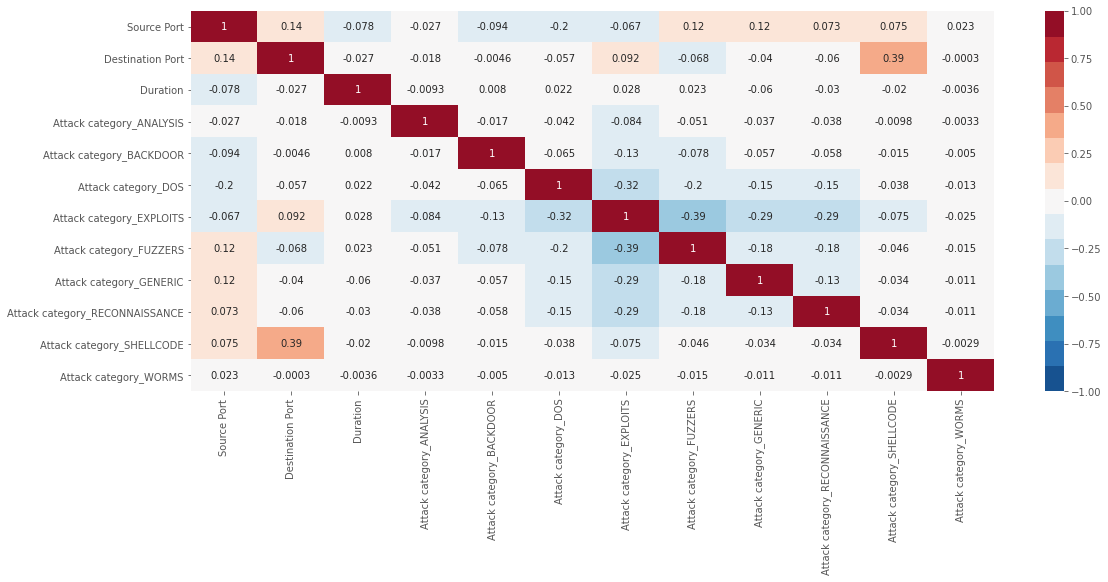

In [42]:
df_dummies = pd.get_dummies(newdf, columns=['Attack category'])
plt.figure(figsize=(18,7))
sns.heatmap(df_dummies.corr(method='pearson'), 
            annot=True, vmin=-1.0, vmax=1.0, cmap=sns.color_palette("RdBu_r", 15))
plt.show()

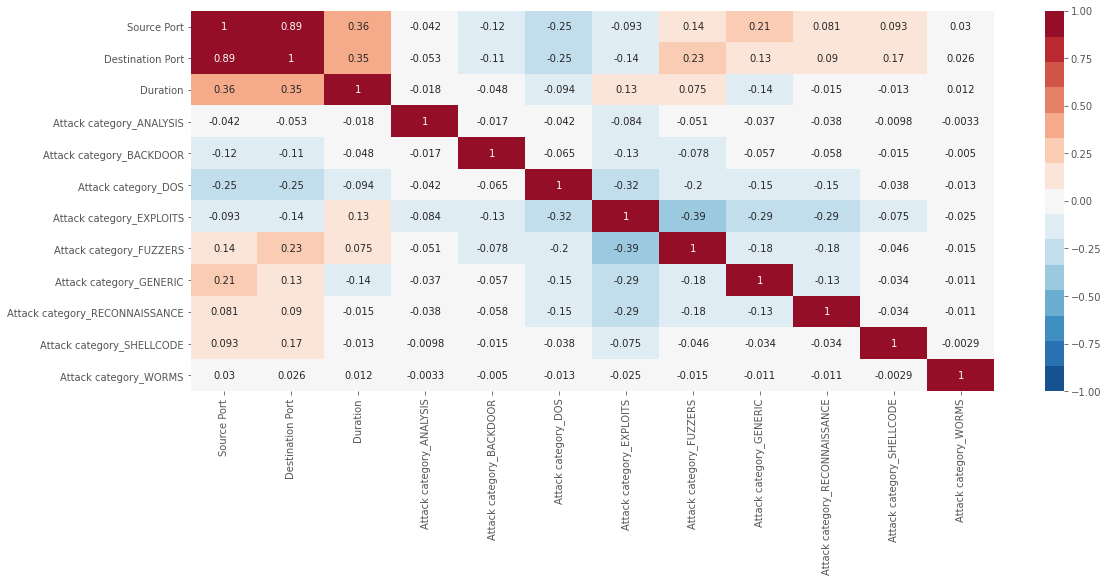

In [43]:
plt.figure(figsize=(18,7))
sns.heatmap(df_dummies.corr(method='spearman'), 
            annot=True, vmin=-1.0, vmax=1.0, cmap=sns.color_palette("RdBu_r", 15))
plt.show()

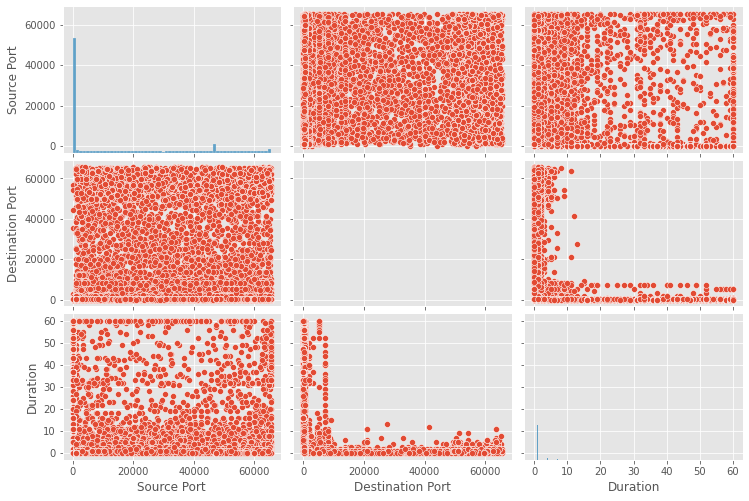

In [44]:
g = sns.pairplot(newdf, palette='red')
g.fig.set_size_inches(11,7)
plt.show()

In [ ]:
# Conclusion from above pairplot, lot of lower destination ports are having a higher duration of attack & for higher destination port attacks are having less duration.
# Now we mill make a scatterplot to increase the visibilty of the observation.

In [45]:
newdf['Destination IP'].value_counts()[:5]

149.171.126.17    43199
149.171.126.10    24002
149.171.126.19    21619
149.171.126.13    20464
149.171.126.18    13301
Name: Destination IP, dtype: int64

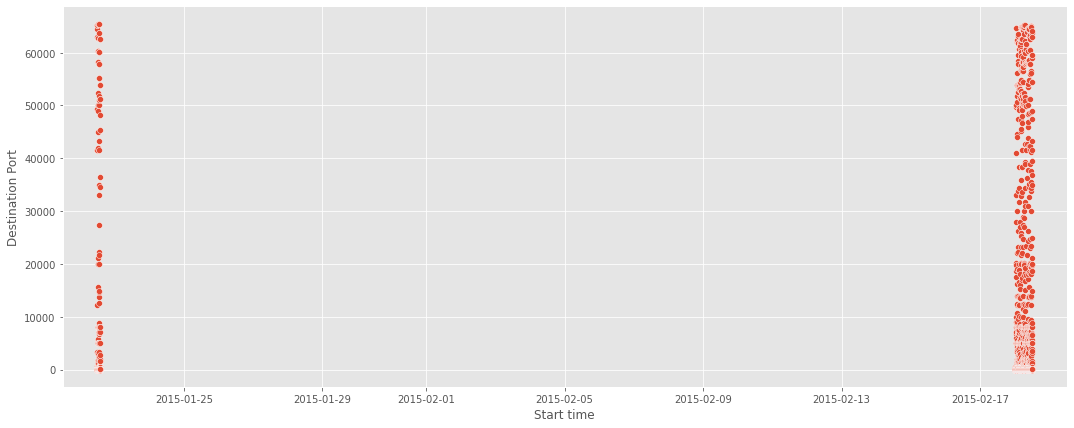

In [46]:
plt.figure(figsize=(18,7))
sns.scatterplot(x=newdf[newdf['Destination IP']=='149.171.126.17']['Start time'], y=newdf[newdf['Destination IP']=='149.171.126.17']['Destination Port'])
plt.xlim(left=newdf['Start time'].min()-timedelta(days=1),right=newdf['Start time'].max()+timedelta(days=1))
plt.grid(True)
plt.show()

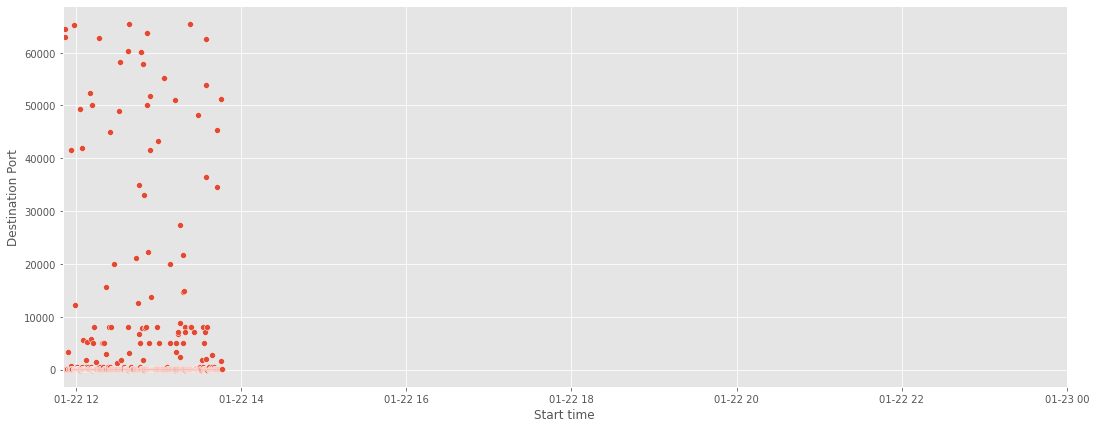

In [47]:
# In above scatterplot we are not able to clearly analyse left & right region thus we will now create separate scatterplot for both.
plt.figure(figsize=(18,7))
sns.scatterplot(x=newdf[newdf['Destination IP']=='149.171.126.17']['Start time'], y=newdf[newdf['Destination IP']=='149.171.126.17']['Destination Port'])
plt.xlim(left=newdf['Start time'].min(),right=datetime.strptime('15-01-23', '%y-%m-%d'))
plt.grid(True)
plt.show()

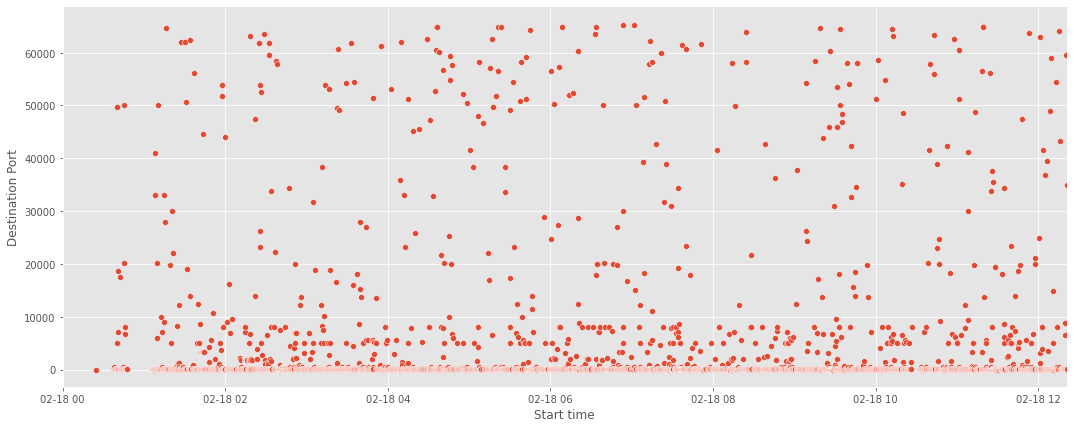

In [48]:
plt.figure(figsize=(18,7))
sns.scatterplot(x=newdf[newdf['Destination IP']=='149.171.126.17']['Start time'], y=newdf[newdf['Destination IP']=='149.171.126.17']['Destination Port'])
plt.xlim(left=datetime.strptime('15-02-18', '%y-%m-%d'),right=newdf['Start time'].max())
plt.grid(True)
plt.show()

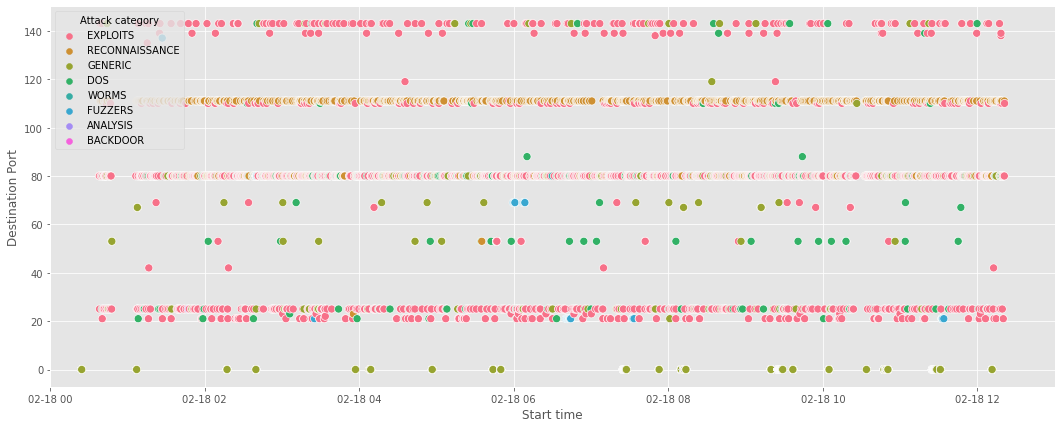

In [49]:
# As we can see from above plot more attacks are on the lower plot, so now we will zoom into the lower range to better anlayse the region
plt.figure(figsize=(18,7))
sns.scatterplot(x='Start time', y='Destination Port', hue='Attack category', data=newdf[(newdf['Destination IP']=='149.171.126.17')&(newdf['Destination Port']<=150)], s=65)
plt.xlim(left=datetime.strptime('15-02-18 00:00:00', '%y-%m-%d %H:%M:%S'), right=datetime.strptime('15-02-18 13:00:00', '%y-%m-%d %H:%M:%S'))
plt.grid(True)
plt.show()

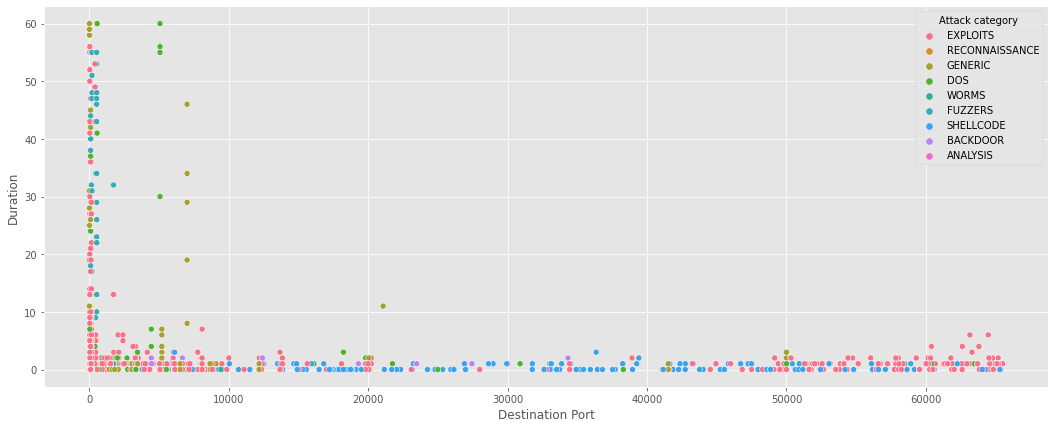

In [50]:
#duration vs destination ports
plt.figure(figsize=(18,7))
sns.scatterplot(x='Destination Port', y='Duration', hue='Attack category', data=newdf[newdf['Destination IP']=='149.171.126.17'])
plt.grid(True)
plt.show()

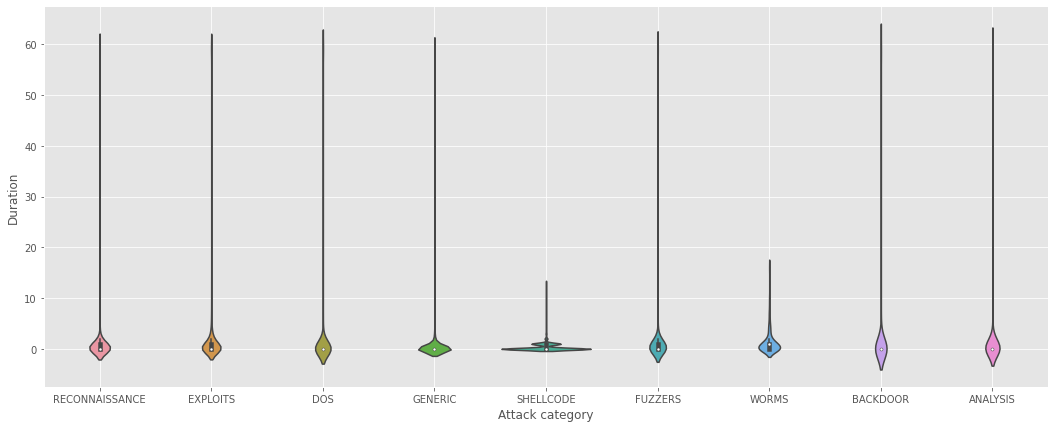

In [51]:
# From above plot, we can conclude attacks on lower destination port lasts longer
# Now, we will create a violin plot form which we will conclude that all the distributions are similar except shellcode as it has 2 peaks
plt.figure(figsize=(18,7))
sns.violinplot(x='Attack category', y='Duration', data=newdf)
plt.grid(True)
plt.show()

In [52]:
def heatmap_graph(df, xlabel, ylabel, title):
    plt.figure(figsize=(18,8))
    ax = sns.heatmap(df)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

In [53]:
# Now we will analyse at what particular hours the attack is getting increased.
newdf["Start time"][1].hour

11

In [54]:
df_pivot = newdf.copy()
df_pivot['hour'] = df_pivot.apply(lambda row: '0'*(2-len(str(row['Start time'].hour)))+str(row['Start time'].hour)+':00:00', axis=1)
df_pivot[:5]

,Attack category,Attack subcategory,Protocol,Source IP,Source Port,Destination IP,Destination Port,Attack Name,Attack Reference,Start time,Last time,Destination Port Service,Duration,hour
0,RECONNAISSANCE,HTTP,TCP,175.45.176.0,13284,149.171.126.16,80,Domino Web Server Database Access: /doladmin.n...,-,2015-01-22 11:50:14,2015-01-22 11:50:16,HTTP,2,11:00:00
1,EXPLOITS,Unix 'r' Service,UDP,175.45.176.3,21223,149.171.126.18,32780,Solaris rwalld Format String Vulnerability (ht...,CVE 2002-0573 (http://cve.mitre.org/cgi-bin/cv...,2015-01-22 11:50:15,2015-01-22 11:50:15,NaN,0,11:00:00
2,EXPLOITS,Browser,TCP,175.45.176.2,23357,149.171.126.16,80,Windows Metafile (WMF) SetAbortProc() Code Exe...,CVE 2005-4560 (http://cve.mitre.org/cgi-bin/cv...,2015-01-22 11:50:16,2015-01-22 11:50:16,HTTP,0,11:00:00
3,EXPLOITS,Miscellaneous Batch,TCP,175.45.176.2,13792,149.171.126.16,5555,HP Data Protector Backup (https://strikecenter...,CVE 2011-1729 (http://cve.mitre.org/cgi-bin/cv...,2015-01-22 11:50:17,2015-01-22 11:50:17,PERSONAL-AGENT,0,11:00:00
4,EXPLOITS,Cisco IOS,TCP,175.45.176.2,26939,149.171.126.10,80,Cisco IOS HTTP Authentication Bypass Level 64 ...,CVE 2001-0537 (http://cve.mitre.org/cgi-bin/cv...,2015-01-22 11:50:18,2015-01-22 11:50:18,HTTP,0,11:00:00


In [55]:
# create a pivot table to observe the pattern
df_p1 = pd.pivot_table(df_pivot,values='Attack Name', index=['hour'], columns=['Attack category'], aggfunc='count')
df_p1

Attack category,ANALYSIS,BACKDOOR,DOS,EXPLOITS,FUZZERS,GENERIC,RECONNAISSANCE,SHELLCODE,WORMS
hour,,,,,,,,,
00:00:00,3,16,127,543,391,60,177,20,3
01:00:00,186,1148,2640,6716,4477,1748,1804,105,14
02:00:00,71,100,630,2861,1983,1031,1023,113,10
03:00:00,226,60,3755,9759,2743,1513,2727,113,17
04:00:00,64,87,617,2776,2090,1349,1034,115,10
05:00:00,198,645,3038,9368,2536,1834,1750,111,15
06:00:00,84,90,637,2968,2065,994,1010,116,9
07:00:00,179,578,3390,6151,2413,2076,1846,116,15
08:00:00,73,111,664,2938,2048,1081,1010,107,11


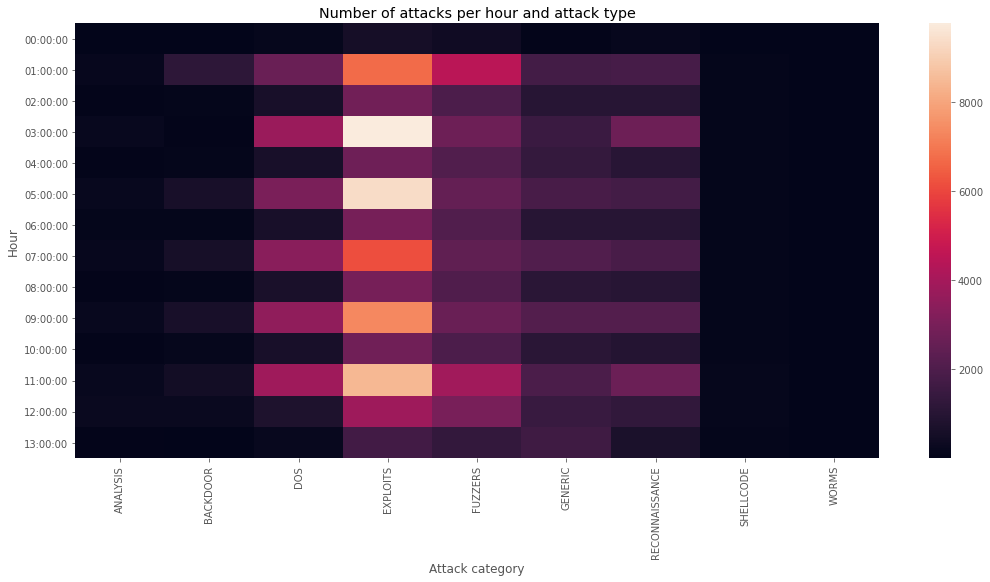

In [56]:
heatmap_graph(df = df_p1, xlabel = 'Attack category', ylabel = 'Hour', title = 'Number of attacks per hour and attack type')
# we can conclude that attacks are more at odd hours, so it can help as to frame security policy accordingly.

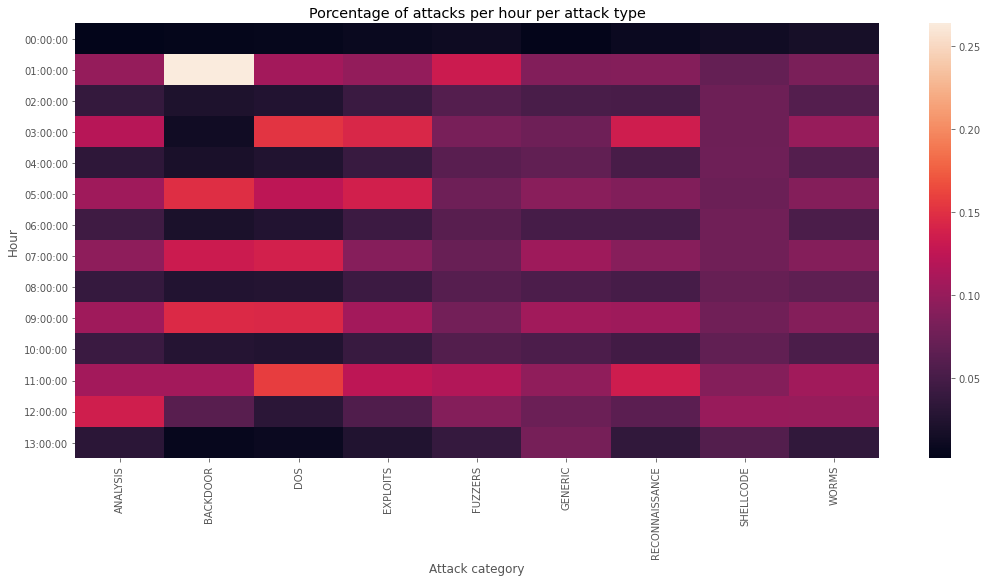

In [57]:
heatmap_graph(df = df_p1/df_p1.sum(), xlabel = 'Attack category', ylabel = 'Hour', title = 'Porcentage of attacks per hour per attack type')

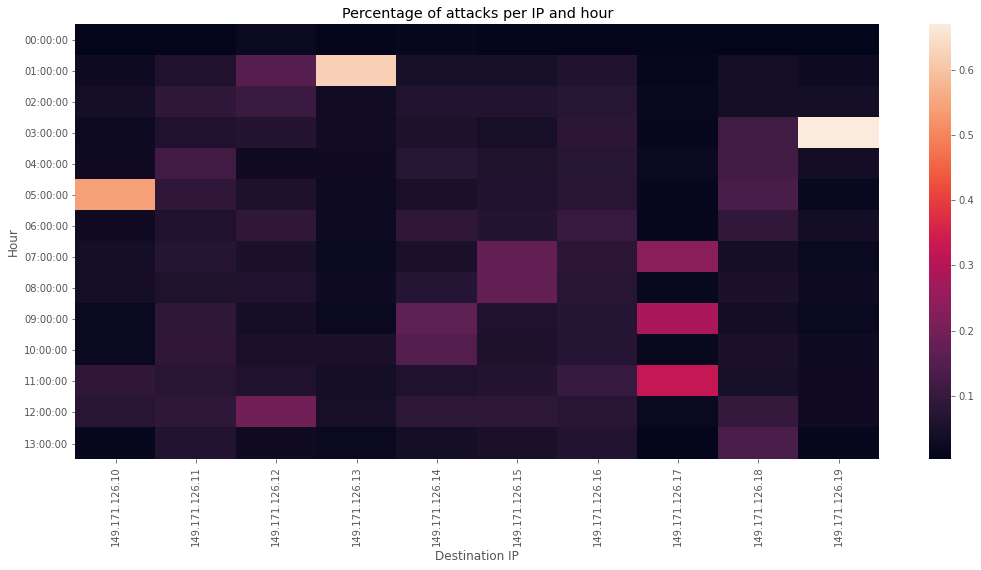

In [58]:
df_p2 = pd.pivot_table(df_pivot, values='Attack Name', index=['hour'], columns=['Destination IP'], aggfunc='count')
heatmap_graph(df = df_p2/df_p2.sum(), xlabel = 'Destination IP', ylabel = 'Hour', title = 'Percentage of attacks per IP and hour')
# we can conclude that at some specific time hacker attacks a particular IP, may be because hackers gets that at this time this particular IP is under backup process or else.

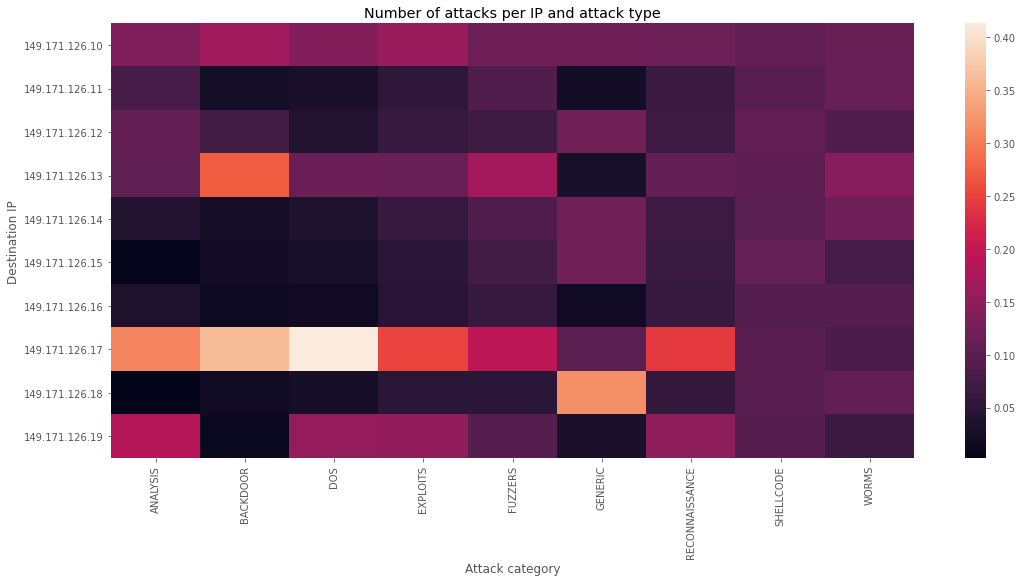

In [59]:
# Although there are more than 170,000 records related to cybersecurity attacks, these attacks target 10 servers with IPv4 addresses in the interval [149.171.126.10,149.171.126.19] . This means that the company was attacked on multiple occasions during the observed timeframe, on a specific subnet, which denotes a non-accidental and directed succession of events.
df_p3 = pd.pivot_table(df_pivot, values='Attack Name', index=['Destination IP'], columns=['Attack category'], aggfunc='count')
heatmap_graph(df = df_p3/df_p3.sum(), xlabel = 'Attack category', ylabel = 'Destination IP', title = 'Number of attacks per IP and attack type')

In [60]:
# The most attacked machine is the one with the IPv4 address 149.171.126.17. Conversely, while worms, shellcode and generic attacks are not directed at particular machines, Denial of Services, Exploits and Backdoor attacks are clearly targeted towards specific servers.
#  now look at this same relationship per attack category performing a pair-wise  T−test :
for attack in list(newdf['Attack category'].unique()):
    df_attack = newdf[newdf['Attack category'] == attack].copy()
    statistic, pvalue = stats.ttest_ind(df_attack['Source Port'], df_attack['Destination Port'], equal_var=False)
    print('p-value in T-test for ' + attack + ' attack: ' + str(pvalue))

p-value in T-test for RECONNAISSANCE attack: 0.0
p-value in T-test for EXPLOITS attack: 0.0
p-value in T-test for DOS attack: 0.0
p-value in T-test for GENERIC attack: 0.0
p-value in T-test for SHELLCODE attack: 0.3205085348227197
p-value in T-test for FUZZERS attack: 0.0
p-value in T-test for WORMS attack: 4.246722648635902e-46
p-value in T-test for BACKDOOR attack: 4.8983630604388355e-17
p-value in T-test for ANALYSIS attack: 9.319524862935004e-87


In [61]:
# As can be seen, the 𝑝-values of all but one attack category are very close to 0.0. This means that the attacks have been directed to the specific ports, except for the Shellcode attacks, whose null hypothesis cannot be rejected. For this type of attack there is a defined randomness, which means that the source and destination ports have similar averages.
# To verify this statement, we will make use of a contingency table which allows to relate the count of a certain pair of variables, similar to how we saw the .pivot_table()
df_crosstab = pd.crosstab(newdf['Attack category'], newdf['Destination Port'])
df_crosstab

Destination Port,0,10,21,22,23,25,31,42,53,67,68,69,80,81,88,89,105,110,111,119,123,135,137,138,139,143,161,162,179,383,389,443,445,446,464,465,497,500,502,513,...,65189,65198,65218,65219,65231,65239,65245,65248,65262,65264,65267,65284,65286,65287,65300,65306,65311,65331,65334,65359,65361,65365,65390,65398,65400,65414,65418,65419,65420,65446,65455,65460,65470,65479,65486,65497,65502,65511,65517,65535
Attack category,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ANALYSIS,1442,0,0,0,0,6,0,0,0,0,0,0,433,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BACKDOOR,4000,0,7,0,0,0,7,0,0,0,0,0,63,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
DOS,20825,4,75,0,13,425,0,0,154,33,0,27,1756,0,38,0,0,90,7,0,18,7,0,7,48,103,14,20,0,0,40,21,91,0,7,3,0,14,20,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
EXPLOITS,40143,0,2198,14,135,4412,0,21,209,98,0,74,11638,7,0,7,0,1558,89,21,0,21,11,14,254,1547,7,0,2,14,75,72,171,7,0,0,0,0,0,53,...,2,2,2,2,2,0,2,2,0,2,0,1,2,2,2,2,2,2,0,2,2,2,2,2,0,0,2,2,2,2,2,2,2,2,2,4,2,2,2,0
FUZZERS,13355,0,758,0,0,0,0,0,0,0,0,190,1386,0,0,0,0,0,0,0,0,583,519,0,0,0,0,0,5464,0,0,0,4659,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GENERIC,2612,0,26,6,0,427,0,0,13438,54,1,144,1672,0,0,0,7,34,12,7,0,0,0,0,0,170,0,7,0,0,28,32,33,0,0,0,13,37,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6
RECONNAISSANCE,8324,0,0,0,7,7,0,0,41,0,0,0,2157,0,0,0,0,0,9507,0,0,0,6,0,0,0,81,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
SHELLCODE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
WORMS,0,0,0,0,0,0,0,0,0,0,0,7,148,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# contingency table of Attack type v/s Target port and the individual counts are not uniform which allows to affirm our inference that there might be an interaction between these two variables. 
# We can formally test whether the variations we observe reflect real differences or are just a by-product of randomness. We will focus on the most widely used test: the Chi-square test.

In [62]:
chi2, p_value, dof, expected = chi2_contingency(df_crosstab)
print("p-value of Chi-square test for Attack category vs. Destination Port =", p_value)
# from result we conclude that 𝑝 -value is extremely small and therefore we reject the null hypothesis and conclude that the attack category and destination port are not independent. In other words, the destination port do not remain the same for different attack categories, what agrees with what we observe previously.

p-value of Chi-square test for Attack category vs. Destination Port = 0.0


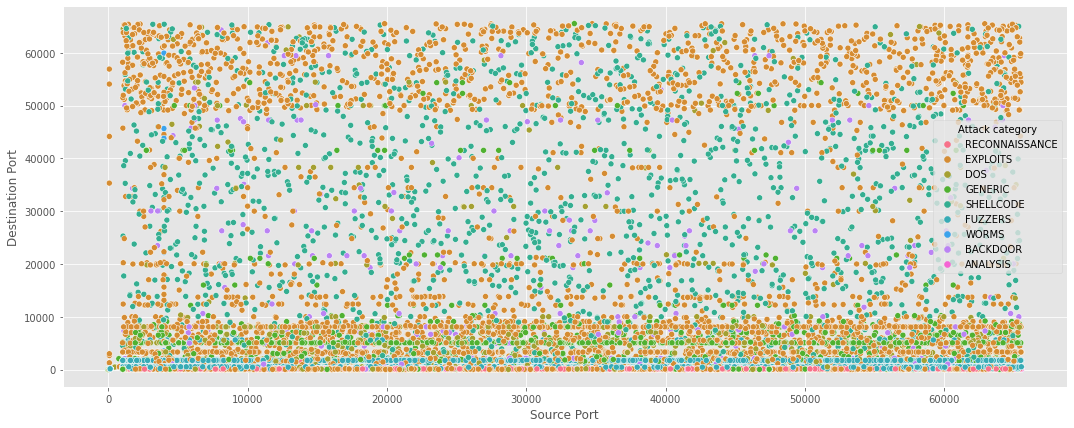

In [63]:
# To visualize this relationship between these variables (source port, destination port, and attack category), we will initially make a scatterplot using the .scatterplot() function between the source and destination ports in terms of the attack category:
plt.figure(figsize=(18,7))
sns.scatterplot(x='Source Port',y='Destination Port', hue='Attack category',data=newdf)
plt.show()

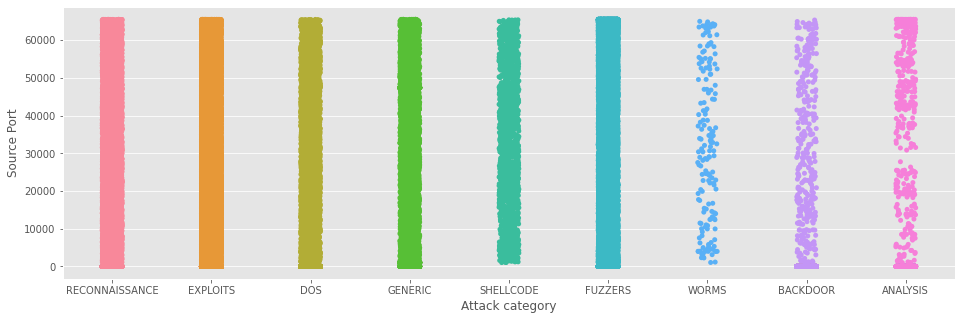

In [64]:
# A certain pattern can be seen in the graph, in which attacks usually occur on ports less than 10,000 or greater than 50,000, except for shellcode-type attacks, as we had anticipated in the hypothesis test.
# To see this relationship more in depth, we can visualize the the distribution of the logical origin and destination ports with a strip diagram
# Source ports
plt.figure(figsize=(16,5))
sns.stripplot(x='Attack category',y='Source Port',data=newdf)
plt.show()

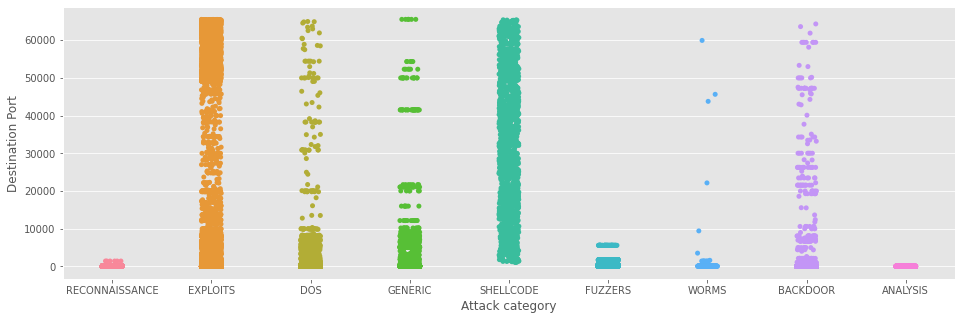

In [65]:
# Destination ports
plt.figure(figsize=(16,5))
sns.stripplot(x='Attack category',y='Destination Port',data=newdf)
plt.show()

In [66]:
# view of the distribution of destination ports by attack category and destination IP
list(newdf['Source IP'].unique())

['175.45.176.0', '175.45.176.3', '175.45.176.2', '175.45.176.1']

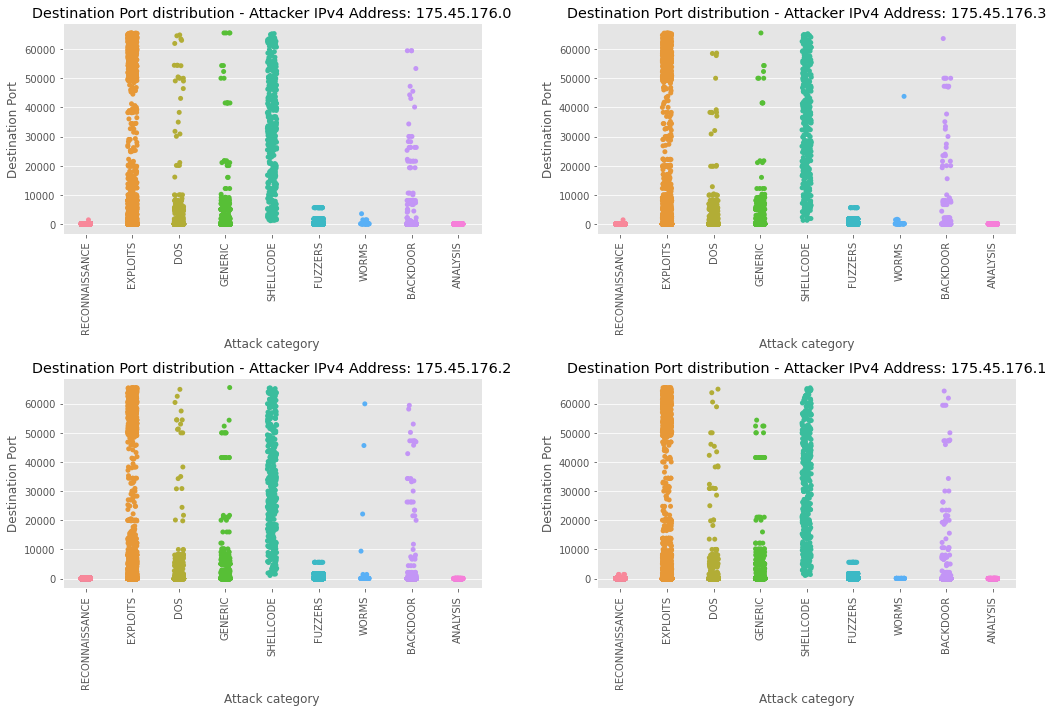

In [67]:
ips = list(newdf['Source IP'].unique())
f, axes = plt.subplots(2, 2)
f.set_figheight(10)
f.set_figwidth(15)

labels = list(newdf['Attack category'].unique())
for i, ip in enumerate(ips):
    sns.stripplot(x='Attack category',y='Destination Port',data=newdf[newdf['Source IP'] == ip], order=labels, ax=axes[int(i/2)][i%2])
    axes[int(i/2)][i%2].set_xlabel('Attack category')
    axes[int(i/2)][i%2].set_ylabel('Destination Port')
    axes[int(i/2)][i%2].set_title('Destination Port distribution - Attacker IPv4 Address: ' + ip)
    axes[int(i/2)][i%2].set_xticklabels(labels,rotation=90)
plt.tight_layout()
plt.show()

In [68]:
newdf.to_csv('drive/MyDrive/BTP/grid-data.csv', encoding='utf-8', index=False)

In [ ]:
# The above graphs show us that there is a differentiation in the way in which the attacks are performing their tasks. There is a particularization by the targets, something that does not happen with the source devices.
# We have explored different types of attack & have analysed which are the ports and time span more vulnerable to attack
# Based on these informations we can propose new security policy & counter measures so that attacks on power grid can be avioded.